<a href="https://colab.research.google.com/github/yusufsugiono/KlasifikasiJudulBerita/blob/main/KlasifikasiJudulBerita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing (NLP) : Klasifikasi Judul Berita

## Data Preparation

### Import Library

In [ ]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

### Download Dataset

In [ ]:
# Download Data
!wget https://raw.githubusercontent.com/zaelani23/KlasifikasiJudulBerita/main/berita.json

--2022-01-12 14:12:39--  https://raw.githubusercontent.com/zaelani23/KlasifikasiJudulBerita/main/berita.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224474 (219K) [text/plain]
Saving to: ‘berita.json’

berita.json         100%[===================>] 219.21K  --.-KB/s    in 0.02s   

2022-01-12 14:12:39 (10.8 MB/s) - ‘berita.json’ saved [224474/224474]



### Loading Dataset

In [ ]:
berita = pd.read_json('berita.json')

## Data Understanding

In [ ]:
berita

,judul,kategori
0,Kini Produk Buatan Tangan UMKM Lebih Dicari da...,Bisnis
1,"Dongkrak Produktivitas Petani, Pupuk Indonesi...",Bisnis
2,Meikarta Mulai Topping Off Area Distrik 2,Bisnis
3,Sederet Inovasi Penyaluran BBM Pertamina di Us...,Bisnis
4,"Daftar Terbaru 50 Orang Terkaya di Indonesia, ...",Bisnis
...,...,...
2137,Lebih Produktif Saat Bekerja di Rumah dengan M...,Tekno
2138,5 Trik Rahasia WhatsApp Ini Patut Kamu Coba,Tekno
2139,Ekonom UI: Kolaborasi Gojek dan Bank Jago Baka...,Tekno
2140,Rahasia Main Game Free Fire Biar Selalu Booyah,Tekno


In [ ]:
berita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   judul     2142 non-null   object
 1   kategori  2142 non-null   object
dtypes: object(2)
memory usage: 33.6+ KB


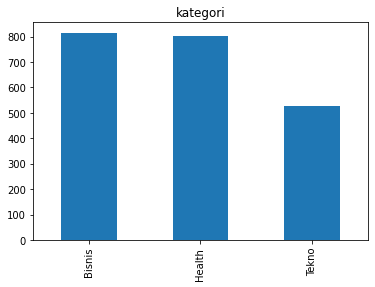

In [ ]:
count = berita['kategori'].value_counts()
count.plot(kind='bar', title='kategori')

## Data Preprocessing

### Casefolding

In [ ]:
berita['judul'] = berita['judul'].str.lower()

berita.head()

,judul,kategori
0,kini produk buatan tangan umkm lebih dicari da...,Bisnis
1,"dongkrak produktivitas petani, pupuk indonesi...",Bisnis
2,meikarta mulai topping off area distrik 2,Bisnis
3,sederet inovasi penyaluran bbm pertamina di us...,Bisnis
4,"daftar terbaru 50 orang terkaya di indonesia, ...",Bisnis


### Removing Punctuation

In [ ]:
berita["judul"] = berita['judul'].str.replace('[^\w\s]','')

berita

,judul,kategori
0,kini produk buatan tangan umkm lebih dicari da...,Bisnis
1,dongkrak produktivitas petani pupuk indonesia...,Bisnis
2,meikarta mulai topping off area distrik 2,Bisnis
3,sederet inovasi penyaluran bbm pertamina di us...,Bisnis
4,daftar terbaru 50 orang terkaya di indonesia s...,Bisnis
...,...,...
2137,lebih produktif saat bekerja di rumah dengan m...,Tekno
2138,5 trik rahasia whatsapp ini patut kamu coba,Tekno
2139,ekonom ui kolaborasi gojek dan bank jago bakal...,Tekno
2140,rahasia main game free fire biar selalu booyah,Tekno


### Removing Stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_word = set(stopwords.words('indonesian'))

berita['judul'] = berita['judul'].apply(lambda x:' '.join([word for word in x.split() if word not in (stop_word)]))

berita

,judul,kategori
0,produk buatan tangan umkm dicari produk massal,Bisnis
1,dongkrak produktivitas petani pupuk indonesia ...,Bisnis
2,meikarta topping off area distrik 2,Bisnis
3,sederet inovasi penyaluran bbm pertamina usia ...,Bisnis
4,daftar terbaru 50 orang terkaya indonesia,Bisnis
...,...,...
2137,produktif rumah menerapkan,Tekno
2138,5 trik rahasia whatsapp patut coba,Tekno
2139,ekonom ui kolaborasi gojek bank jago lahirkan ...,Tekno
2140,rahasia main game free fire biar booyah,Tekno


### One-Hot Encoding

In [ ]:
kategori = pd.get_dummies(berita.kategori)

In [ ]:
berita = pd.concat([berita, kategori], axis=1)
berita = berita.drop(columns='kategori')

In [ ]:
berita

,judul,Bisnis,Health,Tekno
0,produk buatan tangan umkm dicari produk massal,1,0,0
1,dongkrak produktivitas petani pupuk indonesia ...,1,0,0
2,meikarta topping off area distrik 2,1,0,0
3,sederet inovasi penyaluran bbm pertamina usia ...,1,0,0
4,daftar terbaru 50 orang terkaya indonesia,1,0,0
...,...,...,...,...
2137,produktif rumah menerapkan,0,0,1
2138,5 trik rahasia whatsapp patut coba,0,0,1
2139,ekonom ui kolaborasi gojek bank jago lahirkan ...,0,0,1
2140,rahasia main game free fire biar booyah,0,0,1


### Split

In [ ]:
judul = berita['judul']
label = berita[['Bisnis', 'Health', 'Tekno']].values

In [ ]:
judul_latih, judul_test, label_latih, label_test = train_test_split(judul, label, test_size=0.2, random_state=42)

### Tokenize

In [ ]:
pad_type = 'pre'
trunc_type = 'pre'

# Tokenize our training data
tokenizer = Tokenizer(num_words=4100, oov_token='x')

tokenizer.fit_on_texts(judul_latih)


In [ ]:
word_index = tokenizer.word_index
print(len(word_index))

4042


In [ ]:
# Save word_index to a json file
with open('word_index.json', 'w') as fp:
    json.dump(word_index, fp)

# Encode training data sentences into sequences
sekuens_latih = tokenizer.texts_to_sequences(judul_latih)
sekuens_test = tokenizer.texts_to_sequences(judul_test)

# Get max training sequence length
maxlen = max([len(x) for x in sekuens_latih])

# Pad the training sequences
padded_latih = pad_sequences(sekuens_latih, padding=pad_type, truncating=trunc_type, maxlen=maxlen) 
padded_test = pad_sequences(sekuens_test, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [ ]:
maxlen

14

In [ ]:
padded_latih[0]

array([   0,    0,    0,    0,    0,    0,    2,    3, 1731,  792,    6,
        143,  108, 1732], dtype=int32)

In [ ]:
padded_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,  479,  121,    2,
       1385,   25,    3], dtype=int32)

## Modelling

In [ ]:
# tf.keras.backend.clear_session()

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=4100, input_length=maxlen, output_dim=32),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
  ])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
num_epochs = 30
hist = model.fit(padded_latih, label_latih, epochs=num_epochs,
                    validation_data=(padded_test, label_test),
                    verbose=2, callbacks=[callbacks])

Epoch 1/30
54/54 - 6s - loss: 1.0866 - accuracy: 0.3759 - val_loss: 1.0747 - val_accuracy: 0.4848 - 6s/epoch - 113ms/step
Epoch 2/30
54/54 - 1s - loss: 0.9756 - accuracy: 0.5277 - val_loss: 0.7380 - val_accuracy: 0.6224 - 1s/epoch - 21ms/step
Epoch 3/30
54/54 - 1s - loss: 0.5459 - accuracy: 0.7986 - val_loss: 0.4612 - val_accuracy: 0.8368 - 1s/epoch - 20ms/step
Epoch 4/30
54/54 - 1s - loss: 0.2781 - accuracy: 0.9136 - val_loss: 0.4491 - val_accuracy: 0.8392 - 999ms/epoch - 19ms/step
Epoch 5/30
54/54 - 1s - loss: 0.1592 - accuracy: 0.9550 - val_loss: 0.3885 - val_accuracy: 0.8648 - 950ms/epoch - 18ms/step
Epoch 6/30
54/54 - 1s - loss: 0.0928 - accuracy: 0.9749 - val_loss: 0.4014 - val_accuracy: 0.8741 - 1s/epoch - 19ms/step
Epoch 7/30
54/54 - 1s - loss: 0.0664 - accuracy: 0.9842 - val_loss: 0.5033 - val_accuracy: 0.8578 - 1s/epoch - 19ms/step
Epoch 8/30
54/54 - 1s - loss: 0.0516 - accuracy: 0.9866 - val_loss: 0.4461 - val_accuracy: 0.8741 - 1s/epoch - 19ms/step
Epoch 9/30
54/54 - 1s - l

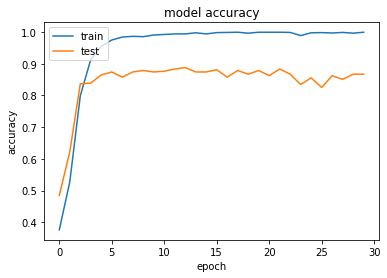

In [ ]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

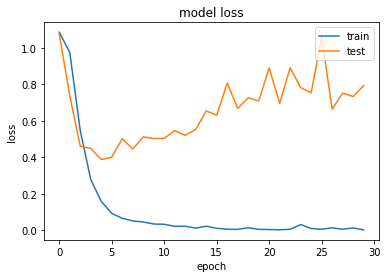

In [ ]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Predict

In [ ]:
#function to make predictions
def make_predictions(model, tokenizer, ml):
  classes = ['Bisnis', 'Health', 'Tekno']
  while True:
    text = input('Masukkan judul berita: ')
    text = [text.lower().replace('[^\w\s]','')]
    t = tokenizer.texts_to_sequences(text)
    t = pad_sequences(t, padding='pre', truncating='pre', maxlen=ml)
    pred_t = model.predict(t)
    print('Prediksi: ', classes[pred_t.argmax()])
    lagi = input('Apakah ingin mencoba lagi? (y/n) :')
    if lagi=='n' or lagi=='N':
      break

In [ ]:
make_predictions(model, tokenizer, maxlen)

Masukkan judul berita: Manfaat Penggunaan Teknologi untuk Pendidikan
Prediksi:  Tekno
Apakah ingin mencoba lagi? (y/n) :y
Masukkan judul berita: 121 Tenaga Kesehatan di RSUD Tarakan Positif Corona
Prediksi:  Health
Apakah ingin mencoba lagi? (y/n) :y
Masukkan judul berita: BRI Raih Berbagai Penghargaan Inovasi Digital Banking
Prediksi:  Bisnis
Apakah ingin mencoba lagi? (y/n) :n



## Save Model

In [ ]:
# Simpan dalam format HDF5
model.save("model.h5")

In [ ]:
# Install tensorflowjs
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 3.5 MB/s 


In [ ]:
# Convert model.h5 ke tfjs_model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model